In [12]:
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# 2-layer NN class implementation

In [25]:
class Neural_Network(object):
    def __init__(self, Lambda=0):  
        '''
        Defines hyperparameters:
            - input layer size is equal to the number of features
              (input layer consists of features values)
            - output layer size is equal to the number of target functions
            - hidden layer size is 3 for this example
        Initializes weights (randomly)
        Set Lambda to the class argument
        '''
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize) #2x3
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize) #3x1
        
        self.Lambda = Lambda
        
    def forward(self, X):
        '''
        Propagates inputs through network
        '''
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        '''
        Applies sigmoid activation function
        '''
        return 1/(1+np.exp(-z))
    
    def sigmoid_grad(self, z):
        '''
        Returns gradient of sigmoid activation function
        '''
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        '''
        Returns MSE cost function
        '''
        self.yHat = self.forward(X)
        J = 0.5 * sum((y - self.yHat)**2) / X.shape[0]\
            + (self.Lambda / 2) * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return J
        
    def costFunction_grads(self, X, y):
        '''
        Returns gradient of MSE cost function as a complete vector
        '''
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y - self.yHat), self.sigmoid_grad(self.z3))
        
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3) / X.shape[0] + self.Lambda * self.W2
        
        delta2 = np.dot(delta3, self.W2.T) * self.sigmoid_grad(self.z2)
        
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2) / X.shape[0] + self.Lambda * self.W1
        
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
    
    def getParams(self):
        '''
        Get W1 and W2 rolled into vector:
        '''
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        '''
        Set W1 and W2 using single parameter vector:
        '''
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize * self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))

def costFunction_numerical_grads(N, X, y):    
        '''
        Returns numerically computed gradient of MSE cost function 
        as a complete vector
        '''
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

### Trainer class

In [26]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        '''
        Makes local reference to network:
        '''
        self.N = N
        
    def callbackF(self, params):
        '''
        Callback function called after each iteration of optimization
        '''
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        '''
        Returns cost function and jacobian(gradient) for optimization
        '''
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.costFunction_grads(X,y)
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        '''
        Trains neural network using scipy optimization method BFGS
        '''
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 500, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True,
                                 method='BFGS', args=(trainX, trainY),
                                 options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

### Auxiliary functions

In [22]:
def normalize(X, mean_std=True):
    '''
    Normalise data before processing
    Return normalized data and normalization parameters
    '''     
    if mean_std:
        means, stds = X.mean(axis=0), X.std(axis=0, ddof=1)
        X = (X - means) / stds
        return X, means, stds
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        X = (X - mins) / (maxs - mins)
        return X, mins, maxs

def denormalize(X, param1, param2, mean_std=True):
    '''
    Denormalize data after processing
    Return denormalized data
    '''
    if mean_std:
        means, stds = param1, param2
        X = X * stds + means
        return X
    else:
        mins, maxs = param1, param2
        X = X * (maxs - mins) + mins
        return X

def plot_cost_changes(T):
    plt.plot(T.J)
    plt.plot(T.testJ)
    plt.grid(1)
    plt.xlabel('Iterations')
    plt.ylabel('Cost function')
    plt.show()

# Data

### Generate dataset

In [53]:
from sklearn import datasets 

sample_size = 200
data, target = datasets.make_regression(n_samples = sample_size,
                                        n_features = 2, 
                                        n_informative = 1, 
                                        n_targets = 1, noise = 5.,
                                        coef = False, random_state = 2)

data,_,_ = normalize(data, False)
target,_,_ = normalize(target, False)

### Split dataset into train & test samples

In [54]:
from sklearn import cross_validation as cross_val

train_data, test_data, \
train_labels, test_labels = cross_val.train_test_split(data, target,
                                                       test_size = 0.3)

In [55]:
train_labels = train_labels.reshape((len(train_labels),1))
test_labels = test_labels.reshape((len(test_labels),1))

### Dataset from the video tutorial

In [65]:
#Data
train_data = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
train_labels = np.array(([75], [82], [93], [70]), dtype=float)

test_data = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
test_labels = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize. Max test score is 100
train_data = train_data / np.max(train_data, axis=0)
train_labels = train_labels / 100

test_data = test_data / np.max(train_data, axis=0)
test_labels = test_labels / 100

In [66]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[ 0.3  1. ]
 [ 0.5  0.2]
 [ 1.   0.4]
 [ 0.6  0.3]] 
...

train_labels: 
 [[ 0.75]
 [ 0.82]
 [ 0.93]
 [ 0.7 ]] ...


In [67]:
#Train network with new data:
NN = Neural_Network(Lambda=0.0001)

In [63]:
#Should be less than 1e-8:
numgrad = costFunction_numerical_grads(NN, train_data, train_labels)
grad = NN.costFunction_grads(train_data, train_labels)
np.linalg.norm(grad - numgrad) / np.linalg.norm(grad + numgrad) < 1e-8

True

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 98
         Function evaluations: 103
         Gradient evaluations: 103


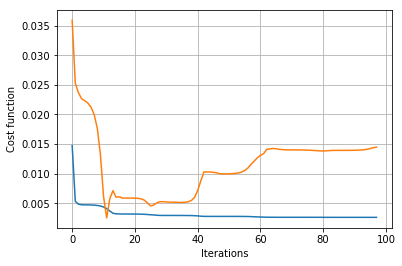

In [64]:
T = trainer(NN)
T.train(train_data, train_labels, test_data, test_labels)

plot_cost_changes(T)